In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

In [204]:
# Stock universe & dates
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'META']
start_date = '2015-01-01'
end_date = '2022-12-01'

In [205]:
# Import Data
prices = yf.download(tickers=stocks, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
monthly_prices = prices.resample('ME').last()
returns = monthly_prices.pct_change()[1:] # Remove first NaN row
prices.head()

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,
2015-01-02,24.237549,15.4260,77.969337,39.858467,0.483038,14.620667
2015-01-05,23.554739,15.1095,76.717064,39.491928,0.474880,14.006000
2015-01-06,23.556961,14.7645,75.683441,38.912281,0.460482,14.085333
2015-01-07,23.887274,14.9210,75.683441,39.406673,0.459282,14.063333
2015-01-08,24.805082,15.0230,77.701004,40.565948,0.476559,14.041333


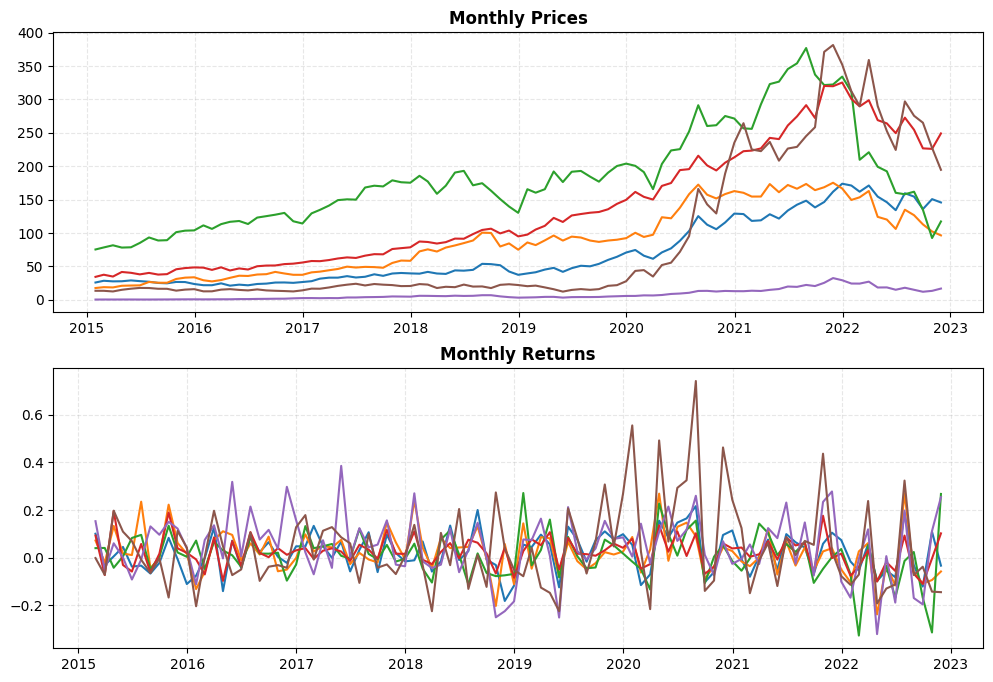

In [206]:
# Plot of the prices & returns
fig, axes = plt.subplots(2, 1, figsize=(12,8))
axes[0].plot(monthly_prices.index, monthly_prices, label=monthly_prices.columns)
axes[1].plot(returns.index, returns)

# Format
axes[0].set_title('Monthly Prices', fontweight='bold')
axes[1].set_title('Monthly Returns', fontweight='bold')
axes[0].grid(alpha=0.3, linestyle='--')
axes[1].grid(alpha=0.3, linestyle='--')

In [207]:
# Get market caps from yfinance and Index Construction
m_caps = []
# Compute Market Cap for each stock
for ticker in stocks:
    ticker = yf.Ticker(ticker)
    m_cap = ticker.info.get('marketCap')
    m_caps.append(m_cap)

# Compute Cap Weights
cap_weights = np.array(m_caps) / np.array(m_caps).sum()

# Compute Cap Weighted Index
cap_idx = (monthly_prices * cap_weights).sum(axis=1)
cap_idx.name = 'Cap Weighted Index'

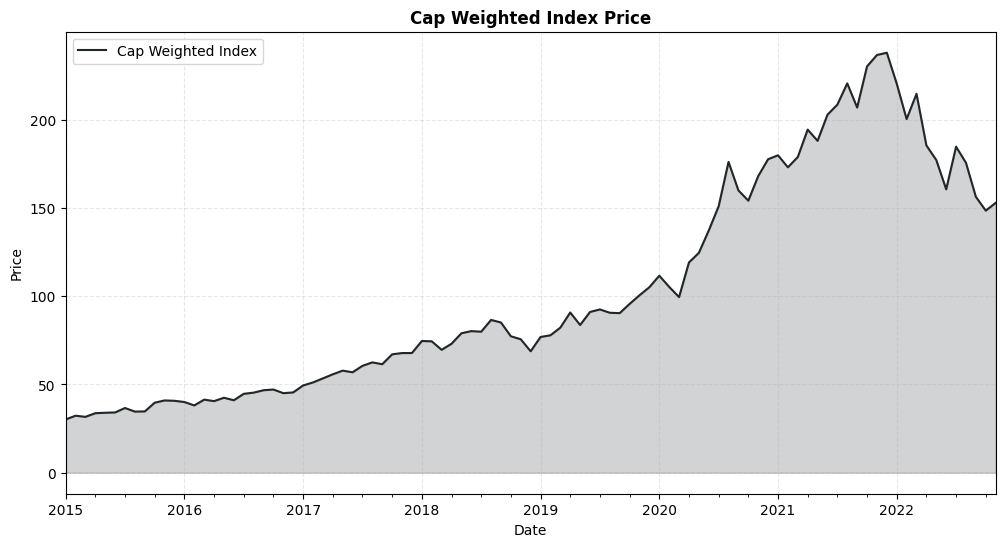

In [208]:
# Plot of the cap weighted index
cap_idx.plot(figsize=(12,6), c="#212628")

# Format
plt.title('Cap Weighted Index Price', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(alpha=0.3, linestyle='--')
plt.fill_between(cap_idx.index, cap_idx, color="#212628", alpha=0.2)
plt.legend()

In [209]:
# Compute Mean-Variance Portfolio Weights
sigma = returns.cov()
mu = returns.mean()
ones = np.ones(len(stocks))

# Numerator
inv_sigma = np.linalg.inv(sigma.values)
num = inv_sigma @ mu

# Denominator
den = num.sum()

# MSR portfolio weights
msr_weights = num / den

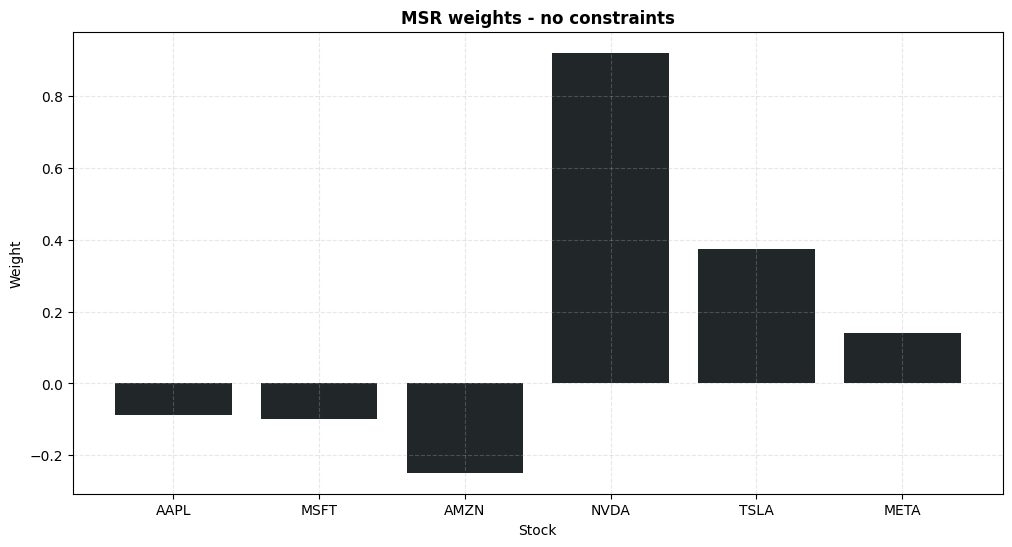

In [210]:
# Plot MSR weights
plt.figure(figsize=(12,6))
plt.bar(stocks, msr_weights, color="#212628")
plt.title('MSR weights - no constraints', fontweight='bold')
plt.ylabel('Weight')
plt.xlabel('Stock')
plt.grid(alpha=0.3, linestyle='--')

Not reliable as it implies to take a strong position in NVDIA which gives a poorly diversified portfolio. Also allow for negative weights (negative positions on some stocks).

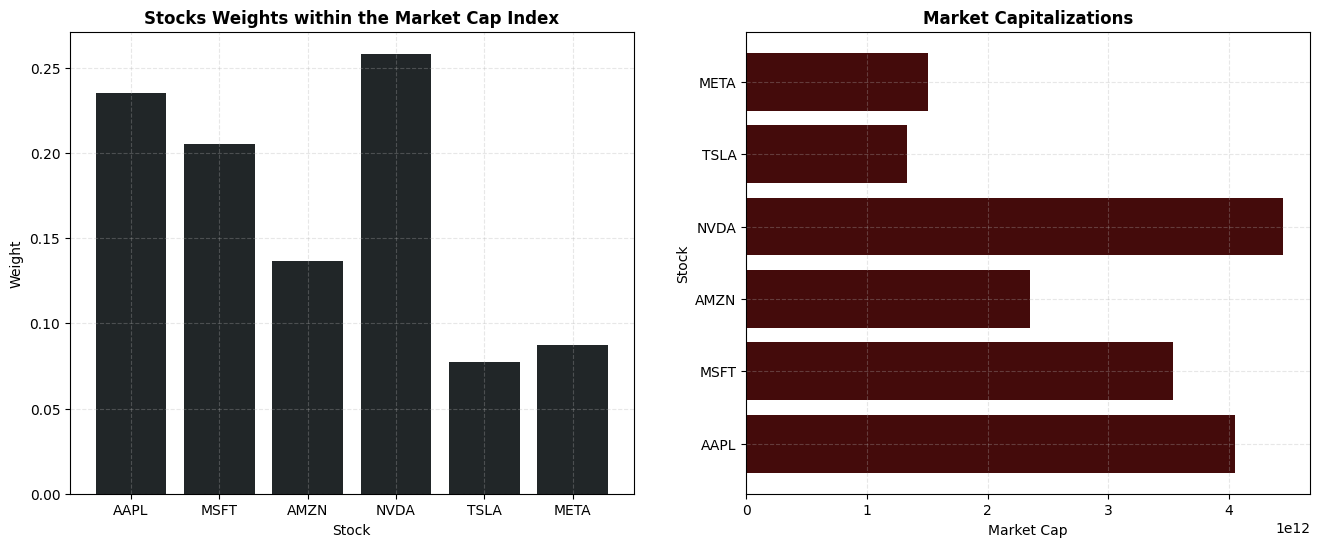

In [211]:
# Plot of the Market Cap Weights
fig, axes = plt.subplots(1,2, figsize=(16,6))

# Weights
axes[0].bar(stocks, cap_weights, color="#212628")
axes[0].set_title('Stocks Weights within the Market Cap Index', fontweight='bold')
axes[0].set_ylabel('Weight')
axes[0].set_xlabel('Stock')
axes[0].grid(alpha=0.3, linestyle='--')

# Market Caps
axes[1].barh(stocks, m_caps, color="#440B0B")
axes[1].set_title('Market Capitalizations', fontweight='bold')
axes[1].set_xlabel('Market Cap')
axes[1].set_ylabel('Stock')
axes[1].grid(alpha=0.3, linestyle='--')

# Step 1

In [212]:
# Compute CAPM implied Expected Returns

# Compute monthly returns of the cap weighted index
cap_idx_rets = (cap_weights * returns).sum(axis=1)
cap_idx_expect_ret = cap_idx_rets.mean()

# Compute Betas for each stock
cov_matrix = returns.cov()
cov_with_mkt = cov_matrix.dot(cap_weights)
betas = cov_with_mkt / cap_idx_rets.var()

# CAPM implied expected returns given rf = 0
imp_expected_rets = betas * cap_idx_expect_ret
imp_expected_rets

Ticker
AAPL    0.023702
AMZN    0.025545
META    0.021118
MSFT    0.018187
NVDA    0.032194
TSLA    0.039981
dtype: float64

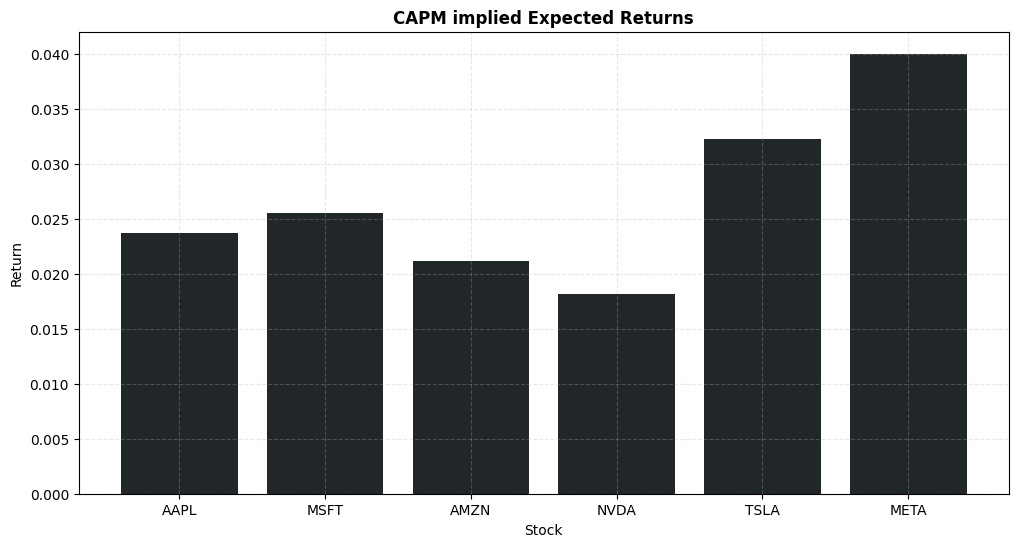

In [213]:
# Plot of CAPM Implied Expected Returns
plt.figure(figsize=(12,6))
plt.bar(stocks, imp_expected_rets, color="#212628")
plt.title('CAPM implied Expected Returns', fontweight='bold')
plt.ylabel('Return')
plt.xlabel('Stock')
plt.grid(alpha=0.3, linestyle='--')

# Step 2

In [214]:
# Specification of Pick Matrix
P = np.array([[1, 0, 0, 0, 0, 0],
             [0, 1, 0, 0, 0, 0],
             [0, 0, 0, 1, -1, 0],
             [0, 0, 0, 0, 1, -1]])

# Specification of the view vector q
q = np.array([[0.1],
              [0.05],
              [0.02],
              [0.01]])

# Specification of the views uncertainty matrix (we keep it as implemented in the course -> tau = 0.05)
tau = 0.05
omega_diag = np.array([tau * (P[k] @ sigma @ P[k].T) 
                       for k in range(P.shape[0])])
omega = np.diag(omega_diag)

# Step 3

In [215]:
# Computation of conditional expected exess returns & Covariance matrix of excess returns

# Expected Returns
mu_capm = imp_expected_rets.values.reshape(-1, 1)
factor = np.linalg.inv(np.linalg.inv(tau * sigma) + 
                       P.T @ np.linalg.inv(omega) @ P)
mu_bl = factor @ (np.linalg.inv(tau * sigma) @ mu_capm + 
                  P.T @ np.linalg.inv(omega) @ q)

# Covariance Matrix
sigma_bl = sigma + np.linalg.inv(np.linalg.inv(tau * sigma) +
                    P.T @ np.linalg.inv(omega) @ P)

In [217]:
# Computation of BL portfolio weights adjusting for the views
weights_bl = (np.linalg.inv(sigma) @ mu_bl) / (ones.T @ np.linalg.inv(sigma) @ mu_bl)

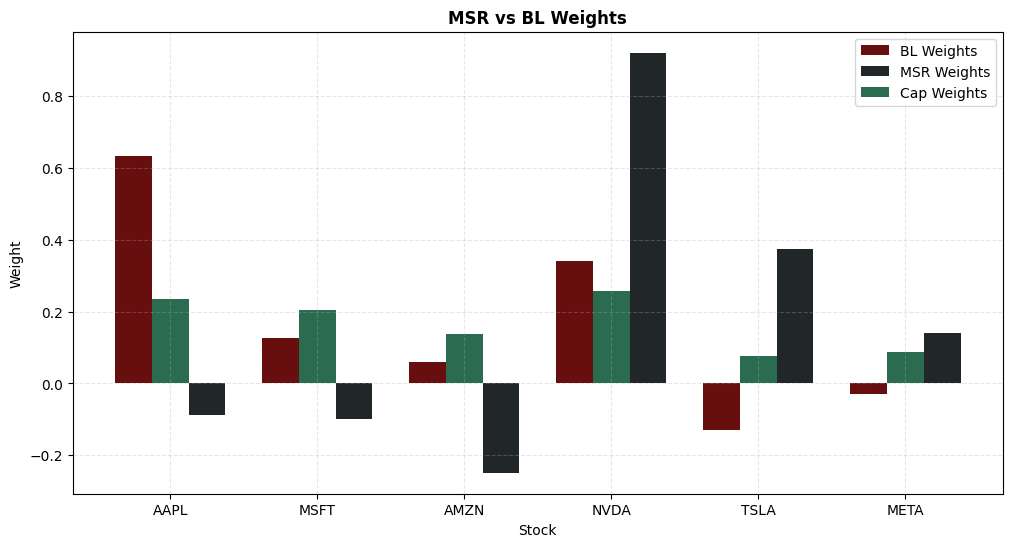

In [223]:
# Visualisation of BL weights
plt.figure(figsize=(12,6))

width = 0.25
x = np.arange(len(stocks))

plt.bar(x-width, weights_bl.flatten(), width, color="#670E0E", label='BL Weights')
plt.bar(x+width, msr_weights, width, color="#212628", label='MSR Weights')
plt.bar(x, cap_weights, width, color="#2B6B50", label='Cap Weights')

plt.title('MSR vs BL Weights', fontweight='bold')
plt.ylabel('Weight')
plt.xlabel('Stock')
plt.xticks(x, stocks)  
plt.grid(alpha=0.3, linestyle='--')
plt.legend()